In [49]:
import numpy as np
import open3d as o3d
import pandas as pd
from scipy.spatial.transform import Rotation


### Parse Data

In [69]:
# helper func: parse pc, convert to arr
def load_point_cloud_with_open3d(file_path, downsample=False):
    pcd = o3d.io.read_point_cloud(file_path) # load pc
    if downsample:
        pcd = pcd.uniform_down_sample(10)
    points = np.asarray(pcd.points) # Open3D.o3d.geometry.PointCloud to numpy array
    return points

# get point cloud (from /HW4_data_files/xx.ply)
pc_gt = load_point_cloud_with_open3d('HW4_data_files/ground_truth.ply', downsample=False) # ground truth
pc1 = load_point_cloud_with_open3d('HW4_data_files/transformed_nonassociated1.ply') # transformed
pc2 = load_point_cloud_with_open3d('HW4_data_files/transformed_nonassociated2.ply') # transformed
pc3 = load_point_cloud_with_open3d('HW4_data_files/transformed_nonassociated3.ply') # transformed


### Step1: Find closet pt

In [70]:
from scipy.spatial import KDTree
import numpy as np

def find_closest_correspondence(source_pc, target_pc):
    """
    Find the closest corresponding points in the target point cloud for each point in the source point cloud using a KD-tree for efficient nearest neighbor search.
    
    Parameters:
    - source_pc: numpy.ndarray or open3d.geometry.PointCloud, the point cloud from which correspondences are to be found.
    - target_pc: numpy.ndarray or open3d.geometry.PointCloud, the point cloud that serves as the target for correspondence matching.
    
    Returns:
    - numpy.ndarray: Corresponding points in the target point cloud for each point in the source point cloud
    """
    # Create a KD-Tree for the target point cloud
    tree_target = KDTree(target_pc)

    # Query the KD-Tree for the nearest neighbor for each point in the source point cloud
    _, indices = tree_target.query(source_pc, workers=-1)

    # Select the corresponding points in the target point cloud using the found indices
    corresponding_points = target_pc[indices]

    # Return the corresponding points
    return corresponding_points



In [52]:
def kabsch_pc_alignment(A, B):
    # A is groundtruth
    assert A.shape == B.shape
    n = A.shape[0]

    # Calculate centroids of the point clouds
    mu_A = np.mean(A, axis=0)
    mu_B = np.mean(B, axis=0)

    # Calculate cross-covariance matrix H
    H = ((B - mu_B).T @ (A - mu_A))/n # normalize if needed?
    U, _, Vt = np.linalg.svd(H)

    # Check if the determinant is negative (special case: reflection instead of rotation)
    if np.linalg.det(Vt.T @ U.T) < 0:
        print("Correct the reflection")
        Vt[-1, :] *= -1  # Flip the sign
        R = (Vt.T @ U.T)

    # Obtain rotation matrix R from H
    R = (Vt.T @ U.T)

    # Obtain the translation vector t from H
    t = mu_A - R @ mu_B

    return R, t

In [53]:
def calculate_mse(pc1, pc2):
    """Calculate the Mean Square Error (MSE) between two point clouds."""
    return np.mean(np.sum((pc1-pc2)**2,axis=1))

In [54]:
def calculate_rotational_error(optimal_R_matrix, gt_quaternion):
    """
    Calculate the rotational error between an optimal rotation matrix and a ground truth quaternion.
    
    Parameters:
    optimal_R_matrix (numpy.ndarray): A 3x3 numpy array representing the optimal rotation matrix.
    gt_quaternion (numpy.ndarray): An array representing the ground truth quaternion.
    
    Returns:
    float: Rotational error in degrees.
    """
    # Create rotation objects from np array
    optimal_R = Rotation.from_matrix(optimal_R_matrix)
    gt_R = Rotation.from_quat(gt_quaternion)
    
    # Calculate the relative rotation matrix
    relative_R_matrix = optimal_R.as_matrix() @ gt_R.as_matrix().T.reshape(3,3)
    relative_R = Rotation.from_matrix(relative_R_matrix)
    
    # Calculate the rotational error (deg)
    rotational_error = np.linalg.norm(relative_R.as_rotvec(degrees=True))
    
    return rotational_error

In [55]:
def load_poses(file_path):
    # Load the CSV file containing the poses
    data = pd.read_csv(file_path)
    # CSV columns are ordered as x,y,z,w, px, py, pz
    quaternions = data[['x', 'y', 'z', 'w']].values
    translations = data[['px', 'py', 'pz']].values
    return quaternions, translations

In [71]:
def ICP(source_pc, target_pc, target_pose, tolerance, max_iterations=200):
    # intialize placeholder for plots
    mse_errors = []
    rotation_errors = []
    translation_errors =[]
    # cumulative_R = np.eye(3)
    # cumulative_t = np.zeros((1, 3))
    T = np.eye(4)

    pc = source_pc
    pc_gt = target_pc

    for i in range(max_iterations):
        # Step 1: Find correspondences
        pc_gt_corr = find_closest_correspondence(pc, pc_gt)

        # Step 2: Find R and t using Kabsch algorithm
        R, t = kabsch_pc_alignment(pc_gt_corr, pc)

        # Step 3: Transform the point cloud by the optimal R and t
        pc = np.dot(pc, R.T) + t
        # Update cumulative transformations
        # cumulative_t = cumulative_t + np.dot(R, t.T).T
        # cumulative_R = np.dot(R, cumulative_R)
        T = np.block([[R, t.reshape(3,1)],
                      [0,0,0,1]]) @ T
        cumulative_R = T[:3,:3]
        cumulative_t = T[:3,3]
        # Step 4: Calculate loss
        cur_loss = calculate_mse(pc, pc_gt_corr)
        mse_errors.append(cur_loss) # for plot

        # Rotation and translation error
        gt_q, gt_t = load_poses(target_pose)
        
        rot_error = calculate_rotational_error(cumulative_R, gt_q)
        rotation_errors.append(rot_error) # for plot
        trans_error = np.linalg.norm(cumulative_t - gt_t, axis=1).reshape(1,)
        translation_errors.append(trans_error) # for plot

        # Print the error every 10 iterations for monitoring
        if i % 5 == 0:
            print(f"Iteration {i}: MSE = {cur_loss:.10f}, rotation error = {rot_error}, translation error = {trans_error}")

        # Check if error is below the threshold
        if len(mse_errors) > 1 and abs(mse_errors[-2] - cur_loss) < tolerance:
            print("ICP convergence achieved. Final error:", cur_loss)
            break
        # if cur_loss<tolerance:
        #     print("ICP convergence achieved. Final error:", cur_loss)
        #     break           
    return cumulative_R, cumulative_t, mse_errors, rotation_errors, translation_errors



Iteration 0: MSE = 10.0239335097, rotation error = 22.007657288548764, translation error = [0.8246644]
Iteration 5: MSE = 0.9333112067, rotation error = 9.015758283554264, translation error = [1.18362066]
Iteration 10: MSE = 0.1709497634, rotation error = 4.049545677871994, translation error = [0.78659812]
Iteration 15: MSE = 0.0380673372, rotation error = 1.8074130740066894, translation error = [0.36107424]
Iteration 20: MSE = 0.0085939963, rotation error = 0.7057334627618465, translation error = [0.13650067]
Iteration 25: MSE = 0.0035034401, rotation error = 0.2330386868504894, translation error = [0.04480555]
Iteration 30: MSE = 0.0028932689, rotation error = 0.06928529608398926, translation error = [0.01333254]
ICP convergence achieved. Final error: 0.0028472010986348665


In [72]:
# RUN
R1, t1, mse1, rot_e1, trans_e1 = ICP(pc1, pc_gt, 'HW4_data_files/gt_pose_nonassociated1.csv', 1e-5)
R2, t2, mse2, rot_e2, trans_e2 = ICP(pc2, pc_gt, 'HW4_data_files/gt_pose_nonassociated2.csv', 1e-5)
R3, t3, mse3, rot_e3, trans_e3 = ICP(pc3, pc_gt, 'HW4_data_files/gt_pose_nonassociated3.csv', 1e-5)


Iteration 0: MSE = 19.2925917838, rotation error = 30.36446699355622, translation error = [1.26466606]
Iteration 5: MSE = 1.9406683932, rotation error = 14.549787374945426, translation error = [1.74591717]
Iteration 10: MSE = 0.6706532295, rotation error = 8.22732864978983, translation error = [1.54387716]
Iteration 15: MSE = 0.1889443404, rotation error = 4.159732673875475, translation error = [0.89442412]
Iteration 20: MSE = 0.0465214501, rotation error = 1.9241927818282747, translation error = [0.40559959]
Iteration 25: MSE = 0.0099952135, rotation error = 0.7571066061542603, translation error = [0.15088013]
Iteration 30: MSE = 0.0036687839, rotation error = 0.2520661150449292, translation error = [0.04881378]
Iteration 35: MSE = 0.0028991390, rotation error = 0.07406206895903132, translation error = [0.01398646]
ICP convergence achieved. Final error: 0.00283524982661662
Iteration 0: MSE = 52.4572842743, rotation error = 59.98004978677806, translation error = [4.16902181]
Iteration 

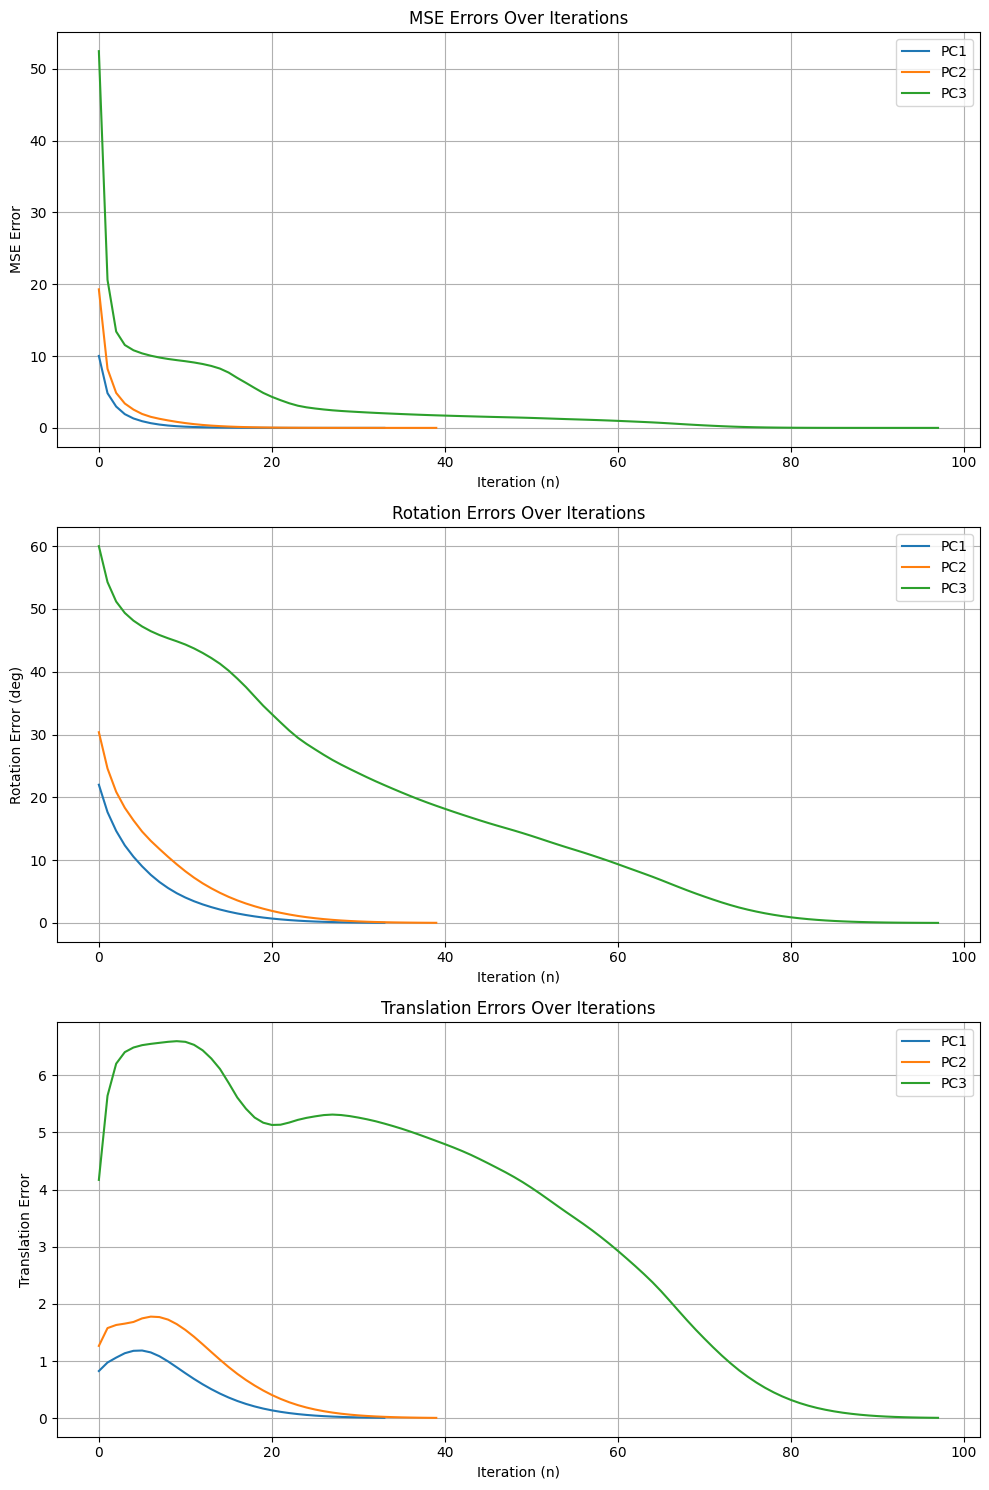

In [74]:
import matplotlib.pyplot as plt

# data for MSE, rotation, and translation errors are defined as mse1, mse2, mse3, rot_e1, rot_e2, rot_e3, trans_e1, trans_e2, trans_e3

# Setting up the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))  # 3 rows, 1 column, each subplot with a height of 7 units

# MSE Errors plot
axs[0].plot(mse1, label='PC1')
axs[0].plot(mse2, label='PC2')
axs[0].plot(mse3, label='PC3')
axs[0].set_xlabel('Iteration (n)')
axs[0].set_ylabel('MSE Error')
axs[0].set_title('MSE Errors Over Iterations')
axs[0].legend()
axs[0].grid(True)

# Rotation Errors plot
axs[1].plot(rot_e1, label='PC1')
axs[1].plot(rot_e2, label='PC2')
axs[1].plot(rot_e3, label='PC3')
axs[1].set_xlabel('Iteration (n)')
axs[1].set_ylabel('Rotation Error (deg)')
axs[1].set_title('Rotation Errors Over Iterations')
axs[1].legend()
axs[1].grid(True)

# Translation Errors plot
axs[2].plot(trans_e1, label='PC1')
axs[2].plot(trans_e2, label='PC2')
axs[2].plot(trans_e3, label='PC3')
axs[2].set_xlabel('Iteration (n)')
axs[2].set_ylabel('Translation Error')
axs[2].set_title('Translation Errors Over Iterations')
axs[2].legend()
axs[2].grid(True)

# Displaying the plot
plt.tight_layout()
plt.show()


## Q3(b) 

In [75]:
def load_color_point_cloud(file_path, downsample=False):
    pcd = o3d.io.read_point_cloud(file_path) # load pc
    if downsample:
        pcd = pcd.uniform_down_sample(10)
    colors = np.asarray(pcd.colors) # -> nparray
    return colors

In [81]:
def find_closest_correspondence_color(source_pc, target_pc):
    tree_target = KDTree(target_pc)
    _, indices = tree_target.query(source_pc, workers=-1)
    corresponding_points = target_pc[indices]
    return corresponding_points, indices

In [85]:
def colored_ICP(source_pc, target_pc, target_pose, tolerance, max_iterations=300, a=0.2):
    # Initialize placeholder for plots
    mse_errors = []
    rotation_errors = []
    translation_errors = []
    T = np.eye(4)

    # Load point clouds
    pc = load_point_cloud_with_open3d(source_pc)
    pc_gt = load_point_cloud_with_open3d(target_pc, downsample=False)

    # Load color point clouds
    color = load_color_point_cloud(source_pc)
    color_gt = load_color_point_cloud(target_pc, downsample=False)
    print(f'pc {pc.shape}, color {color.shape}')

    for i in range(max_iterations):
        # Step 1: Find correspondences
        _, indices = find_closest_correspondence_color(pc, pc_gt)
        
        # Get the corresponding points and colors
        pc_gt_corr = pc_gt[indices]
        color_gt_corr = color_gt[indices]
        
        # Step 1.5: Reject outliers based on color distance
        color_distances = np.linalg.norm(color - color_gt_corr, axis=1)
        
        # Create a mask for valid pairs
        valid_pairs = color_distances <= a
        
        # Filter the point clouds, colors, and indices using the valid pairs mask
        pc_filtered = pc[valid_pairs]
        pc_gt_corr_filtered = pc_gt_corr[valid_pairs]
        # color_filtered = color[valid_pairs]
        # print("pc_gt_corr_filtered:", pc_gt_corr_filtered.shape)

        # Step 2: Find R and t using Kabsch algorithm
        R, t = kabsch_pc_alignment(pc_gt_corr_filtered, pc_filtered)

        # Step 3: Transform the point cloud by the optimal R and t
        pc = np.dot(pc, R.T) + t  # Update the entire point cloud for next iteration
        # Update cumulative transformations
        T = np.block([[R, t.reshape(3, 1)],
                      [0, 0, 0, 1]]) @ T
        cumulative_R = T[:3, :3]
        cumulative_t = T[:3, 3]

        # Step 4: Calculate loss
        cur_loss = calculate_mse(pc_filtered, pc_gt_corr_filtered)
        mse_errors.append(cur_loss)  # for plot

        # Rotation and translation error
        gt_q, gt_t = load_poses(target_pose)
        
        rot_error = calculate_rotational_error(cumulative_R, gt_q)
        rotation_errors.append(rot_error)  # for plot
        trans_error = np.linalg.norm(cumulative_t - gt_t)
        translation_errors.append(trans_error)  # for plot

        # Print the error every 10 iterations for monitoring
        if i % 5 == 0:
            print(f"Iteration {i}: MSE = {cur_loss:.10f}, rotation error = {rot_error}, translation error = {trans_error}")

        # Check if error is below the threshold
        if len(mse_errors) > 1 and abs(mse_errors[-2] - cur_loss) < tolerance:
            print("ICP convergence achieved. Final error:", cur_loss)
            break

    return cumulative_R, cumulative_t, mse_errors, rotation_errors, translation_errors


In [83]:
target = 'HW4_data_files/ground_truth.ply'
source1 = 'HW4_data_files/transformed_nonassociated1.ply'
source2 = 'HW4_data_files/transformed_nonassociated2.ply'
source3 = 'HW4_data_files/transformed_nonassociated3.ply'

# Example usage:
R1_color, t1_color, mse1_color, rot_e1_color, trans_e1_color = colored_ICP(source1, target, 'HW4_data_files/gt_pose_nonassociated1.csv', 1e-5)


pc (187766, 3), color (187766, 3)
pc_gt_corr_filtered: (61620, 3)
Iteration 0: MSE = 14.6795436301, rotation error = 21.938988248780213, translation error = 0.8323850147208148
pc_gt_corr_filtered: (70884, 3)
pc_gt_corr_filtered: (76815, 3)
pc_gt_corr_filtered: (83313, 3)
pc_gt_corr_filtered: (90660, 3)
pc_gt_corr_filtered: (95379, 3)
Iteration 5: MSE = 0.8698751153, rotation error = 7.780976503316262, translation error = 1.0182444632557683
pc_gt_corr_filtered: (100093, 3)
pc_gt_corr_filtered: (104089, 3)
pc_gt_corr_filtered: (108074, 3)
pc_gt_corr_filtered: (112386, 3)
pc_gt_corr_filtered: (116470, 3)
Iteration 10: MSE = 0.1244412594, rotation error = 3.1266657462085727, translation error = 0.5765668757938301
pc_gt_corr_filtered: (120314, 3)
pc_gt_corr_filtered: (124838, 3)
pc_gt_corr_filtered: (129005, 3)
pc_gt_corr_filtered: (132838, 3)
pc_gt_corr_filtered: (136803, 3)
Iteration 15: MSE = 0.0234231500, rotation error = 1.2259721205369298, translation error = 0.23023317216267314
pc_gt

In [86]:
R2_color, t2_color, mse2_color, rot_e2_color, trans_e2_color = colored_ICP(source2, target, 'HW4_data_files/gt_pose_nonassociated2.csv', 1e-5)
R3_color, t3_color, mse3_color, rot_e3_color, trans_e3_color = colored_ICP(source3, target, 'HW4_data_files/gt_pose_nonassociated3.csv', 1e-5)

pc (187766, 3), color (187766, 3)
Iteration 0: MSE = 22.8279066664, rotation error = 33.252802484965464, translation error = 1.1230437749594644
Iteration 5: MSE = 2.5997616149, rotation error = 14.737750217449676, translation error = 1.6070988396358876
Iteration 10: MSE = 0.6286610532, rotation error = 7.081434665702314, translation error = 1.2799663593865647
Iteration 15: MSE = 0.1263942136, rotation error = 3.0227823157686244, translation error = 0.619760559512334
Iteration 20: MSE = 0.0236325555, rotation error = 1.1779471305680074, translation error = 0.23227311824895464
Iteration 25: MSE = 0.0054943131, rotation error = 0.40026261584106015, translation error = 0.07606450016805076
Iteration 30: MSE = 0.0030991432, rotation error = 0.11693015060128316, translation error = 0.022031368295957757
Iteration 35: MSE = 0.0028749628, rotation error = 0.03209062704528571, translation error = 0.005839119375855221
ICP convergence achieved. Final error: 0.0028658440687373728
pc (187766, 3), col

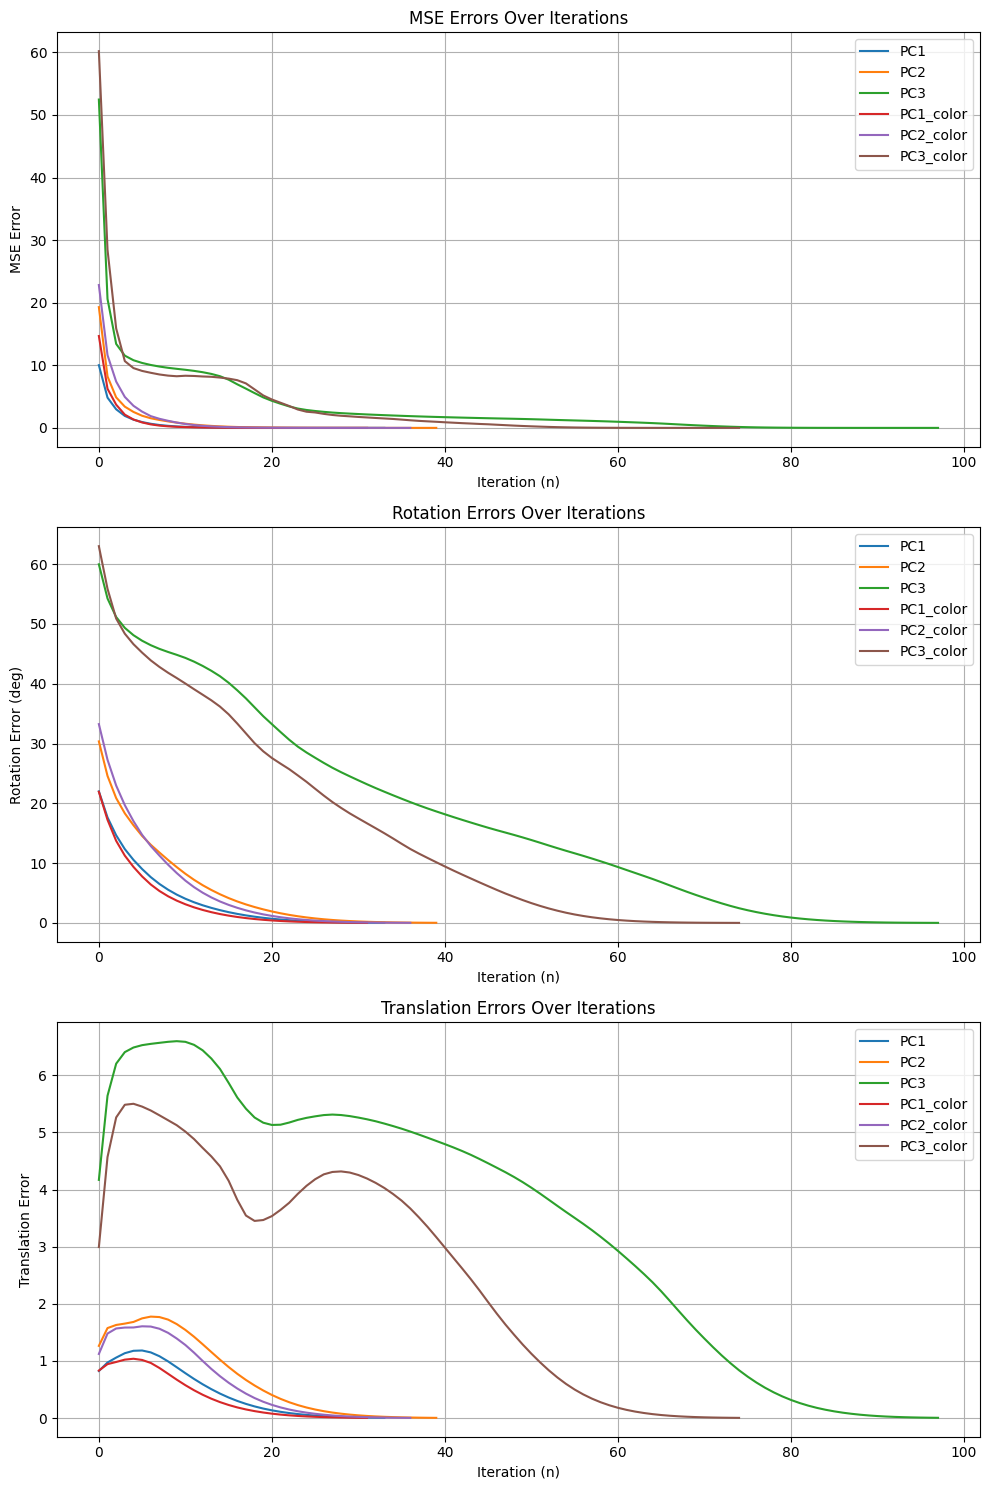

In [87]:
import matplotlib.pyplot as plt

# data for MSE, rotation, and translation errors are defined as mse1, mse2, mse3, rot_e1, rot_e2, rot_e3, trans_e1, trans_e2, trans_e3

# Setting up the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))  # 3 rows, 1 column, each subplot with a height of 7 units

# MSE Errors plot
axs[0].plot(mse1, label='PC1')
axs[0].plot(mse2, label='PC2')
axs[0].plot(mse3, label='PC3')
axs[0].plot(mse1_color, label='PC1_color')
axs[0].plot(mse2_color, label='PC2_color')
axs[0].plot(mse3_color, label='PC3_color')
axs[0].set_xlabel('Iteration (n)')
axs[0].set_ylabel('MSE Error')
axs[0].set_title('MSE Errors Over Iterations')
axs[0].legend()
axs[0].grid(True)

# Rotation Errors plot
axs[1].plot(rot_e1, label='PC1')
axs[1].plot(rot_e2, label='PC2')
axs[1].plot(rot_e3, label='PC3')
axs[1].plot(rot_e1_color, label='PC1_color')
axs[1].plot(rot_e2_color, label='PC2_color')
axs[1].plot(rot_e3_color, label='PC3_color')
axs[1].set_xlabel('Iteration (n)')
axs[1].set_ylabel('Rotation Error (deg)')
axs[1].set_title('Rotation Errors Over Iterations')
axs[1].legend()
axs[1].grid(True)

# Translation Errors plot
axs[2].plot(trans_e1, label='PC1')
axs[2].plot(trans_e2, label='PC2')
axs[2].plot(trans_e3, label='PC3')
axs[2].plot(trans_e1_color, label='PC1_color')
axs[2].plot(trans_e2_color, label='PC2_color')
axs[2].plot(trans_e3_color, label='PC3_color')
axs[2].set_xlabel('Iteration (n)')
axs[2].set_ylabel('Translation Error')
axs[2].set_title('Translation Errors Over Iterations')
axs[2].legend()
axs[2].grid(True)

# Displaying the plot
plt.tight_layout()
plt.show()
